## CME241: Markov Processes and Markov Reward Processes

### Question 1


If we model the game of *Snakes and Ladders* as an MP, we have the state space S = {0,1,...,99,100} where 0 is the starting state and 100 is the terminal state. If we ignore snakes and ladders, the transition probability from state $s$ to to $s+1,s+2...,s+6$ is $\frac{1}{6}$. We can use mapping $M: S \rightarrow S $ in our model to account for snakes and ladders. For example, if $s+1$ is mapped to $s+10$ in the ladder mapping, the transition probability from $s$ to $s+1$ will be replaced with zero and from $s$ to $s+10$ will be $\frac{1}{6}$. Another edge case when the next state is > 100, the player remains where he is.

### Question 2


In [1]:
from dataclasses import dataclass
from typing import Mapping, Dict
from rl.distribution import Choose, Constant
from rl.markov_process import Transition, FiniteMarkovProcess
import matplotlib.pyplot as plt
import numpy as np

In [2]:
snakes = {
    16: 6,
    47: 26,
    49: 11,
    56: 53,
    62: 19,
    64: 60,
    87: 24,
    93: 73,
    95: 75,
    98: 78
}

ladders = {
    1: 38, 
    4: 14, 
    9: 31,
    28: 84,
    21: 42,
    36: 44,
    51: 67,
    71: 91,
    80: 100
}

In [3]:
#Create a transition map
sl_transition_map: Transition[int]= {}
states = [s for s in range(100) if s not in snakes and s not in ladders] #non-terminal states
for state in states:
    destinations = []
    for roll_value in range(1,7):
        next_state = state + roll_value
        #replace next states if snake or ladder
        if next_state in snakes:
            next_state = snakes[next_state]
        if next_state in ladders:
            next_state = ladders[next_state]
        #piece does not move if next state is above 100
        if next_state > 100:
            next_state = state
        destinations.append(next_state)
    #select an element of the given list uniformly at random
    sl_transition_map[state] = Choose(destinations)
sl_transition_map[100] = None #winning condition (terminal state)

In [4]:
#model the game as an instance of FiniteMarkovProcess
game = FiniteMarkovProcess(sl_transition_map)

In [5]:
#use the method traces to create sampling traces
time_steps = []
num_simulations = 0
for trace in game.traces(Constant(0)):
    time_steps.append(len(list(trace)))
    num_simulations += 1
    if num_simulations > 10000:
        break

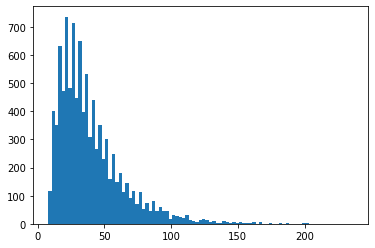

In [6]:
#Plot a graph of the probability distribution of time steps to finish the game.
plt.hist(x=time_steps, bins='auto');

In [7]:
print("The expected number of steps to finish the game is {}.".format(np.mean(time_steps)))

The expected number of steps to finish the game is 40.08109189081092.


### Question 3


Here, we make slight changes to Q2 solutions to solve the frog puzzle. Given a frog and a distance n, we have the state space S = {0,1,...,n} where 0 is the starting state and n is the terminal state. At state $s$, it can jump to $s+1, ..., n$ with equal probability. 



In [8]:
#Create a transition map
def get_frog_transition_map(n: int):
    frog_transition_map: Transition[int]= {}
    states = [s for s in range(n)] #non-terminal states
    for state in states:
        destinations = []
        for num_steps in range(1,n-state+1):
            next_state = state + num_steps
            destinations.append(next_state)
        frog_transition_map[state] = Choose(destinations)
    frog_transition_map[n] = None #terminating condition when frog reaches the end
    return frog_transition_map

In [9]:
#model the game as an instance of FiniteMarkovProcess
dist = 10
frog_game = FiniteMarkovProcess(get_frog_transition_map(dist))

In [10]:
#use the method traces to create sampling traces
num_jumps = []
num_simulations = 0
for trace in frog_game.traces(Constant(0)):
    #the number of steps in each simulation will be the number of states visited - 1 (not counting start state)
    num_jumps.append(len(list(trace))-1)
    num_simulations += 1
    if num_simulations > 10000:
        break
exp_num_jumps = np.mean(num_jumps)
print("For distance of {}, the expected number of jumps is {}.".format(dist, exp_num_jumps))

For distance of 10, the expected number of jumps is 2.9212078792120786.


### Question 4


We can model Q2 as an MRP by adding a reward of 1 for every transition, and using discount rate $\gamma = 1$. Then, we can use the value function of state $s$ will give the expected number of dice rolls to finish the game from that state. We can apply the value function to the starting state $s = 0$.

In [12]:
from rl.markov_process import FiniteMarkovRewardProcess

In [13]:
sl_reward_transition_map = {}
for state, next_dist in sl_transition_map.items():
    if next_dist:
        destinations = [(next_state, 1) for next_state in next_dist.options]
        sl_reward_transition_map[state] = Choose(destinations)
    else:
        sl_reward_transition_map[state] = None

In [14]:
sl_mrp = FiniteMarkovRewardProcess(sl_reward_transition_map)

In [15]:
exp_num_steps = sl_mrp.get_value_function_vec(1)[0]
print("The expected number of steps to finish the game is {}.".format(exp_num_steps))

The expected number of steps to finish the game is 36.96052442581669.
